In [3]:
import numpy as np
from PIL import Image
import os
import sys
import time
hspath = os.path.abspath('./HWS/')
if hspath not in sys.path:
    sys.path.append(hspath)

from HS_Image import *
from HS_Centroids import *
from HS_Gradients import *
from HS_WFP  import *
import HSM_WFN
import matplotlib.pylab as plt


In [4]:
# import HSM_Zernike to analyse HOA:
import HSM_Zernike
import importlib
importlib.reload(HSM_Zernike)

<module 'HSM_Zernike' from '/Users/georgia.mansell/git/sams_shws/HWS/HSM_Zernike.py'>

In [5]:
## Recompute sphericla power using 1 set average:
ref_dir = "./data/20191111_1/ref/"
data_dir = "./data/20191111_1/"
ref_name0 = 'ref_0'
file0 = Image.open(ref_dir+ref_name0+'.tif')
ref0 = np.array(file0)[:,:,0]
hsi_ref0 = HS_Image()
hsi_ref0.original_image = ref0
hsi_ref0.background = 0
hsi_ref0.process_image()
#hsi_ref0.modified_image = np.log10(hsi_ref0.modified_image + 2)
hsc_ref0 = HS_Centroids()
hsc_ref0.hsimage = hsi_ref0
hsc_ref0.radius = 10
hsc_ref0.find_centroids()

ref_name1 = 'ref_1'
file1 = Image.open(ref_dir+ref_name1+'.tif')
ref1 = np.array(file1)[:,:,0]
hsi_ref1 = HS_Image()
hsi_ref1.original_image = ref1
hsi_ref1.background = 0
hsi_ref1.process_image()
#hsi_ref1.modified_image = np.log10(hsi_ref1.modified_image + 2)
hsc_ref1 = HS_Centroids()
hsc_ref1.hsimage = hsi_ref1
hsc_ref1.radius = 10
hsc_ref1.find_centroids()
print(np.shape(hsc_ref0.centroids))

(477, 2)


In [6]:
origin = array([534.69596094, 511.1660639 ])

In [7]:
# Investigate set 0 up and down:
Vu_file = []
Vd_file = []
Vu= np.arange(25,175,25)
Vd= np.arange(0,150,25)
path = ['u','d']
sets = [0,1]
Vu_all = np.tile(Vu,2)
Vd_all = np.tile(Vd,2)

for iP in path:
    if iP == 'u':
        for iV in Vu:
            for iS in sets:
                Vu_file.append('V{iV}_u{iS}/live_{iS}.tif'.format(iV=iV,iS=iS))
    else:
        for iV in Vd:
            for iS in sets:
                Vd_file.append('V{iV}_d{iS}/live_{iS}.tif'.format(iV=iV,iS=iS))
                
#print(Vu_file, Vd_file)
#P0 = [-229,-238,-246,-250,-261,-264,-275,-276,-286,-290,-297,-305]
Pu = [-238,-250,-264,-276,-290,-305,-240,-251,-264,-277,-291,-305]
Pd = [-229,-246,-261,-275,-286,-297,-229,-246,-261,-275,-286,-297]
Su = [] 
Cu = []
Sd = [] 
Cd = []
phiu = []
phid = []
for iS in sets:
    # setting referenc
    if iS == 0:
        hsc_ref = hsc_ref0
    elif iS == 1:
        hsc_ref = hsc_ref1
    for iP in path:
        if iP == 'u':
            V_file=Vu_file
        else:
            V_file=Vd_file
        for ifile in range(0+iS,len(V_file),2):
            file = Image.open(data_dir+V_file[ifile])
            live = np.array(file)[:,:,0]
            hsi_live = HS_Image()
            hsi_live.original_image = live
            hsi_live.background = 0
            hsi_live.process_image()
            #hsi_live.modified_image = np.log10(hsi_live.modified_image + 2)
            hsc_live = HS_Centroids()
            hsc_live.hsimage = hsi_live
            hsc_live.radius = 10
            hsc_live.find_centroids_using_template(hsc_ref.centroids)
            hsg_raw = HS_Gradients(hsc_ref, hsc_live)
            hsg_raw.lever_arm = 4.1e-3
            hsg_raw.magnification = 1/0.71
            hsg_raw.pixel_size = 2*5.86e-6
            hsg_raw.construct_gradients()
            grad_notilt = hsg_raw.gradients[:,:2]-np.mean(hsg_raw.gradients[:,:2],axis=0)
            hsc_live1 = HS_Centroids()
            hsc_live1.centroids = hsc_ref.centroids + grad_notilt*(hsg_raw.lever_arm*hsg_raw.magnification/(hsg_raw.pixel_size))
            hsg = HS_Gradients(hsc_ref, hsc_live1)
            hsg.pixel_size = hsg_raw.pixel_size
            hsg.magnification = hsg_raw.magnification
            hsg.lever_arm = hsg_raw.lever_arm
            hsg.construct_gradients()
            hsg.origin = origin
            hsg.construct_gradients()
            # Find  spherical power using fitting polynomial:
            hswfp = HS_WFP(hsg)
            #w1 = (hsc_ref.intensities/np.max(hsc_ref.intensities))
            #w = np.vstack((w1,w1)).transpose()
            hswfp.compute_poly_coeffs()
            hswfp.compute_seidel_coeffs()
            if iP == 'u':
                Su.append(hswfp.seidel_coeffs['spherical_power'])
                Cu.append(hswfp.seidel_coeffs['cylindrical_power'])
                phiu.append(hswfp.seidel_coeffs['phi'])
            else:
                Sd.append(hswfp.seidel_coeffs['spherical_power'])
                Cd.append(hswfp.seidel_coeffs['cylindrical_power'])
                phid.append(hswfp.seidel_coeffs['phi'])
            print(V_file[ifile], np.shape(hsc_ref.centroids))

V25_u0/live_0.tif (477, 2)
V50_u0/live_0.tif (477, 2)
V75_u0/live_0.tif (477, 2)
V100_u0/live_0.tif (477, 2)
V125_u0/live_0.tif (477, 2)
V150_u0/live_0.tif (477, 2)
V0_d0/live_0.tif (477, 2)
V25_d0/live_0.tif (477, 2)
V50_d0/live_0.tif (477, 2)
V75_d0/live_0.tif (477, 2)
V100_d0/live_0.tif (477, 2)
V125_d0/live_0.tif (477, 2)
V25_u1/live_1.tif (477, 2)
V50_u1/live_1.tif (477, 2)
V75_u1/live_1.tif (477, 2)
V100_u1/live_1.tif (477, 2)
V125_u1/live_1.tif (477, 2)
V150_u1/live_1.tif (477, 2)
V0_d1/live_1.tif (477, 2)
V25_d1/live_1.tif (477, 2)
V50_d1/live_1.tif (477, 2)
V75_d1/live_1.tif (477, 2)
V100_d1/live_1.tif (477, 2)
V125_d1/live_1.tif (477, 2)


In [8]:
# Fitting polynomial to hysteresis behaviours:
Su1 = np.array(Su)
Su1 = np.concatenate((Su1,[Sd[0],Sd[6]]))
zu = np.polyfit(np.concatenate((Vu_all,[0,0])), Su1, 4)
pu= np.poly1d(zu)
V_fit = np.linspace(0,150,200)
Su_fit = pu(V_fit)

Sd1 = np.array(Sd)
Sd1 = np.concatenate((Sd1,[Su[5],Su[11]]))
zd = np.polyfit(np.concatenate((Vd_all,[150,150])), Sd1, 4)
pd= np.poly1d(zd)
Sd_fit = pd(V_fit)

Sall = np.concatenate((np.array(Su),np.array(Sd)))
Pall = np.concatenate((np.array(Pu),np.array(Pd)))
zP = np.polyfit(Pall, Sall, 1)
pP= np.poly1d(zP)
VP_fit = np.linspace(Pall.min(), Pall.max(),100)
SP_fit = pP(VP_fit)

In [9]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

Text(0, 0.5, 'Defocus [mD]')

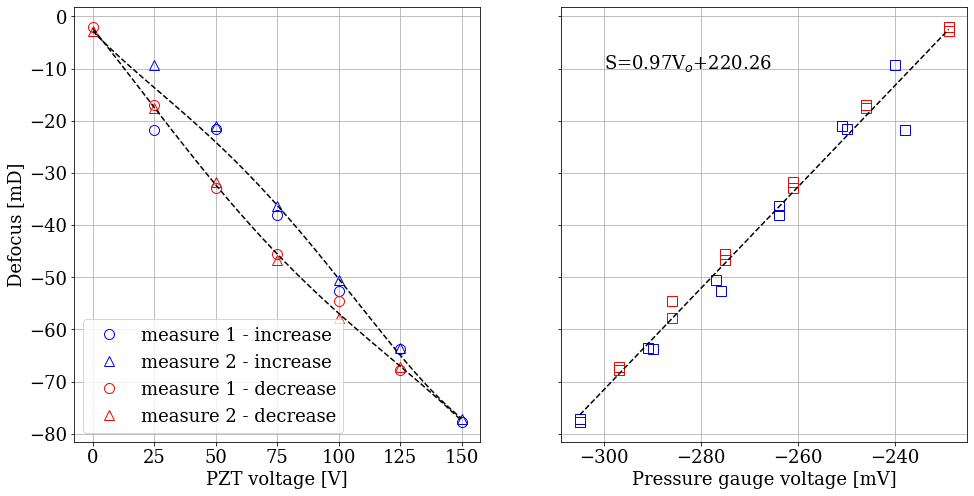

In [10]:
# Plot spherical power and input voltage  + pressure gauge voltage:
fig, axs = plt.subplots(1,2,figsize=(16,8),sharey=True)
axs[0].plot(Vu_all[:6],1e3*np.array(Su)[:6],'ob',ms=10,mfc='none',label='measure 1 - increase')
axs[0].plot(Vu_all[6:],1e3*np.array(Su)[6:],'^b',ms=10,mfc='none',label='measure 2 - increase')
axs[0].plot(Vd_all[:6],1e3*np.array(Sd)[:6],'or',ms=10,mfc='none',label='measure 1 - decrease')
axs[0].plot(Vd_all[6:],1e3*np.array(Sd)[6:],'^r',ms=10,mfc='none',label='measure 2 - decrease')
axs[0].plot(V_fit,1e3*Su_fit,'--k',ms=10,mfc='none')
axs[0].plot(V_fit,1e3*Sd_fit,'--k',ms=10,mfc='none')

axs[1].plot(Pu,1e3*np.array(Su),'sb',ms=10,mfc='none')
axs[1].plot(Pd,1e3*np.array(Sd),'sr',ms=10,mfc='none')
axs[1].plot(VP_fit,1e3*SP_fit,'--k',ms=10,mfc='none')
axs[1].text(-300,-10,r'S={p0}V$_o$+{p1}'.format(p0=np.around(1e3*zP[0],2),p1=np.around(1e3*zP[1],2) ))

axs[0].legend()
axs[0].grid(which='both')
axs[1].grid(which='both')
axs[0].set_xlabel('PZT voltage [V]')
axs[1].set_xlabel('Pressure gauge voltage [mV]')
axs[0].set_ylabel('Defocus [mD]')


-0.07775726448834204 [-0.021858222955984802, -0.02162528678523192, -0.038086743825737644, -0.05272688824841614, -0.06370435972486282, -0.07775726448834204, -0.009271467177478307, -0.02101710654349118, -0.03626018184180325, -0.05049117178964188, -0.06348270278595376, -0.07710070727576135]


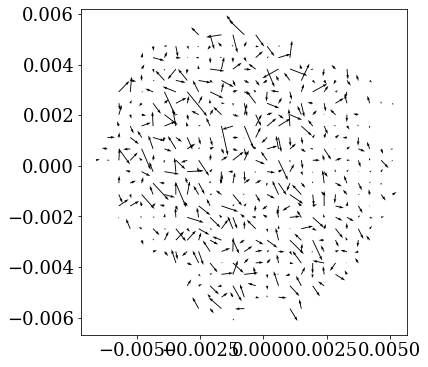

In [11]:
file_name ='V150_u0/live_0.tif'
file = Image.open(data_dir+file_name)
live = np.array(file)[:,:,0]
hsi_live = HS_Image()
hsi_live.original_image = live
hsi_live.background = 0
hsi_live.process_image()
#hsi_live.modified_image = np.log10(hsi_live.modified_image + 2)
hsc_live = HS_Centroids()
hsc_live.hsimage = hsi_live
hsc_live.radius = 10
hsc_live.find_centroids_using_template(hsc_ref0.centroids)
hsg_raw = HS_Gradients(hsc_ref0, hsc_live)
hsg_raw.lever_arm = 4.1e-3
hsg_raw.magnification = 1/0.71
hsg_raw.pixel_size = 2*5.86e-6
hsg_raw.construct_gradients()
grad_notilt = hsg_raw.gradients[:,:2]-np.mean(hsg_raw.gradients[:,:2],axis=0)
hsc_live1 = HS_Centroids()
hsc_live1.centroids = hsc_ref0.centroids + grad_notilt*(hsg_raw.lever_arm*hsg_raw.magnification/(hsg_raw.pixel_size))
hsg = HS_Gradients(hsc_ref0, hsc_live1)
hsg.pixel_size = hsg_raw.pixel_size
hsg.magnification = hsg_raw.magnification
hsg.lever_arm = hsg_raw.lever_arm
hsg.origin = origin
hsg.construct_gradients()
hswfp = HS_WFP(hsg)
hswfp.compute_poly_coeffs()
hswfp.compute_seidel_coeffs()
cents = hsg.gradients[:,2:]
Sgrads = -hswfp.seidel_coeffs['spherical_power']*cents
resgrads = hsg.gradients[:,:2]-Sgrads
plt.figure(figsize=(10,6))
plt.quiver(hsg.gradients[:,2],hsg.gradients[:,3],resgrads[:,0],resgrads[:,1])
plt.gca().set_aspect('equal')
print(hswfp.seidel_coeffs['spherical_power'], Su)

In [12]:
## Using Zernike to evaluateboth defocus and higher order abberation:
iorder =  50
ratio = 1
Rmax = np.min([abs(hsg.gradients[:,2].min()),hsg.gradients[:,2].max(),abs(hsg.gradients[:,3].min()),hsg.gradients[:,3].max()]) # Radius of circular pupil over which Zernikecoeffs are evaulated
bcoeff = HSM_Zernike.compute_Zernike_from_hsg(hsg,iorder,R0=ratio*Rmax)

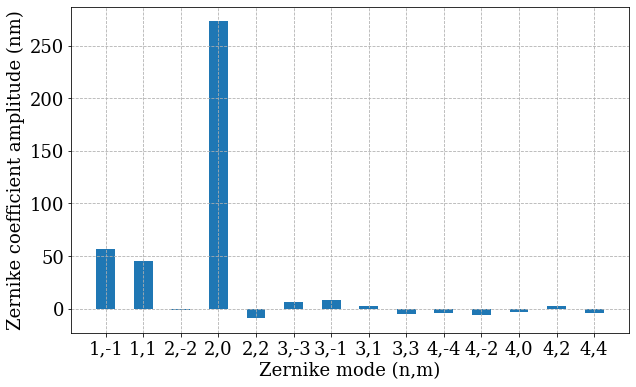

In [13]:
HSM_Zernike.bar_plot_zernike(bcoeff, i=None, logplot = False)

In [14]:
x = np.linspace(-1,1,300)
y = np.linspace(-1,1,300)
X,Y = np.meshgrid(x,y)
R,PHI = HSM_Zernike.cart2pol(X,Y)
wfZ = HSM_Zernike.construct_wf(R,PHI, bcoeff)
wfZ[X**2+Y**2>1]=np.nan
wfZ -= np.nan_to_num(wfZ).max()

# Find  centroid of the region:
from scipy.ndimage.measurements import center_of_mass as com
com_wf = np.rint(com(np.nan_to_num(wfZ))).astype(int) # centroid given in term of idex
# centroi in term of X,Y
xcent = Rmax*ratio*X[com_wf[0],com_wf[1]] # given in term of metric unit
ycent = Rmax*ratio*Y[com_wf[0],com_wf[1]]  # given in term of metric unit
# Reconstruct the origin in pixel value in hsg_gradients using the new centroids
xcent_p = xcent/(hsg.magnification*hsg.pixel_size)
ycent_p = ycent/(hsg.magnification*hsg.pixel_size)
origin_new = origin+[xcent_p,ycent_p]
# Reset the origin so we analyse the center of deformation
hsg.origin = origin_new
hsg.construct_gradients()
Rmax = np.min([abs(hsg.gradients[:,2].min()),hsg.gradients[:,2].max(),abs(hsg.gradients[:,3].min()),hsg.gradients[:,3].max()]) # Radius of circular pupil over which Zernikecoeffs are evaulated
bcoeff = HSM_Zernike.compute_Zernike_from_hsg(hsg,iorder,R0=ratio*Rmax)

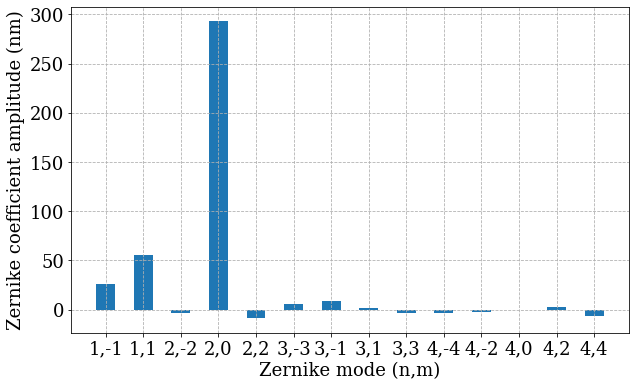

In [15]:
HSM_Zernike.bar_plot_zernike(bcoeff, i=None, logplot = False)

Defocus:  71.89610044970625  mD
Astigmatism: 0.9966896982358316  mD
Astigmatism angle: 122.73233272869592


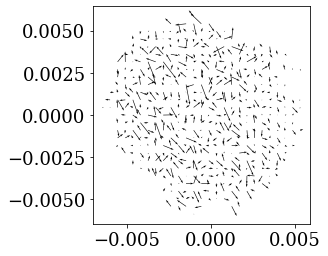

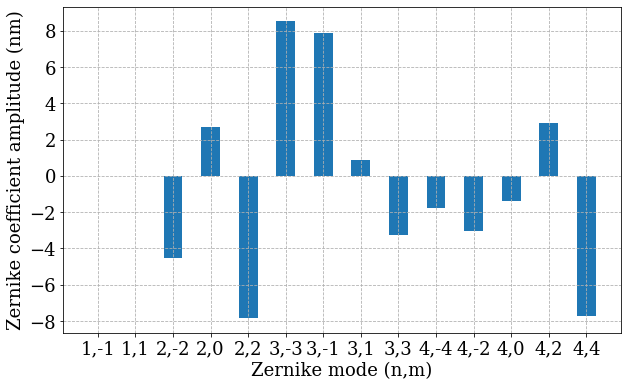

In [16]:
Rmax = np.min([abs(hsg.gradients[:,2].min()),hsg.gradients[:,2].max(),abs(hsg.gradients[:,3].min()),hsg.gradients[:,3].max()]) # Radius of circular pupil over which Zernikecoeffs are evaulated
W20 = 2*sqrt(3)*(bcoeff[3]) - 6*sqrt(5)*(bcoeff[11])-sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
W22 = 2*sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
W40 = 6*sqrt(5)*(bcoeff[11]) 
S = 2*W20/(ratio*Rmax)**2
As =  W22/(ratio*Rmax)**2
theta = np.rad2deg((np.arctan(bcoeff[4]/bcoeff[5])+np.pi)%(2*np.pi))
# Construct the axis of astigmatism
r1_x =  1*np.cos(np.deg2rad(theta)-np.pi)
r1_y =  1*np.sin(np.deg2rad(theta)-np.pi)
r2_x =  1*np.cos(np.deg2rad(theta))
r2_y =  1*np.sin(np.deg2rad(theta))
#Rs = 2/0.02
Rs = 2/S
print('Defocus: ',1e3*S,' mD')
print('Astigmatism:', 1e3*As,' mD')
print('Astigmatism angle:', theta)
# Costruct wavefront with reoval of spherical component 
cents = hsg.gradients[:,2:]
hsg_S = HSM_Zernike.construct_spherical_gradient(Rs, cents)

hsg_noS = HSM_Zernike.construct_residual_gradient(hsg, Rs)
bcoeff_noS = HSM_Zernike.compute_Zernike_from_hsg(hsg_noS,iorder,R0=ratio*Rmax)
plt.quiver(hsg.gradients[:,2], hsg.gradients[:,3], hsg.gradients[:,0]-hsg_S[:,0], hsg.gradients[:,1]- hsg_S[:,1])
plt.gca().set_aspect('equal')
bcoeff_noS[:2]=0
HSM_Zernike.bar_plot_zernike(bcoeff_noS, i=None, logplot = False)

In [17]:
# Numerically integrate full wavefront:
gspacing = Rmax*ratio*(x[1]-x[0])
cents = hsg.gradients[:,2:]
limits = {}
limits['x'] = array([-Rmax*ratio,Rmax*ratio])
limits['y'] = array([-Rmax*ratio,Rmax*ratio])
wfn = HSM_WFN.calculate_wf(hsg.gradients[:,2:],hsg.gradients[:,:2],limits, gspacing)
wfn[X**2+Y**2>1]=np.nan
wfn -= np.min((np.nan_to_num(wfn))[np.nonzero(np.nan_to_num(wfn))])
wfn -= np.nan_to_num(wfn).mean()
p

In [18]:
# Numerically integrated wavefront after defocus removal:
#hsg_noS.gradients[:,:2] -=  np.mean(hsg_noS.gradients[:,:2],axis=0)
wfn_noS = HSM_WFN.calculate_wf(hsg_noS.gradients[:,2:],hsg_noS.gradients[:,:2],limits, gspacing)
wfn_noS[X**2+Y**2>1]=np.nan
wfn_noS -= np.min((np.nan_to_num(wfn_noS))[np.nonzero(np.nan_to_num(wfn_noS))])
wfn_noS -= np.nan_to_num(wfn_noS).mean()

In [19]:
# Numerically integrated removing all quadratic compoenet:
poly_coeffs = zeros(shape(hswfp.poly_coeffs_array))
poly_coeffs[0:5] = hswfp.poly_coeffs_array[0:5] # remove all quadratic component
gradients_quad = hswfp.calculate_gradients(poly_coeffs)
gradients_noquad = hsg.gradients[:,0:2] - gradients_quad
wfn_noquad = HSM_WFN.calculate_wf(hsg.gradients[:,2:],gradients_noquad,limits, gspacing)
wfn_noquad[X**2+Y**2>1]=np.nan
wfn_noquad -= np.min((np.nan_to_num(wfn_noquad))[np.nonzero(np.nan_to_num(wfn_noquad))])
wfn_noquad -= np.nan_to_num(wfn_noquad).mean()

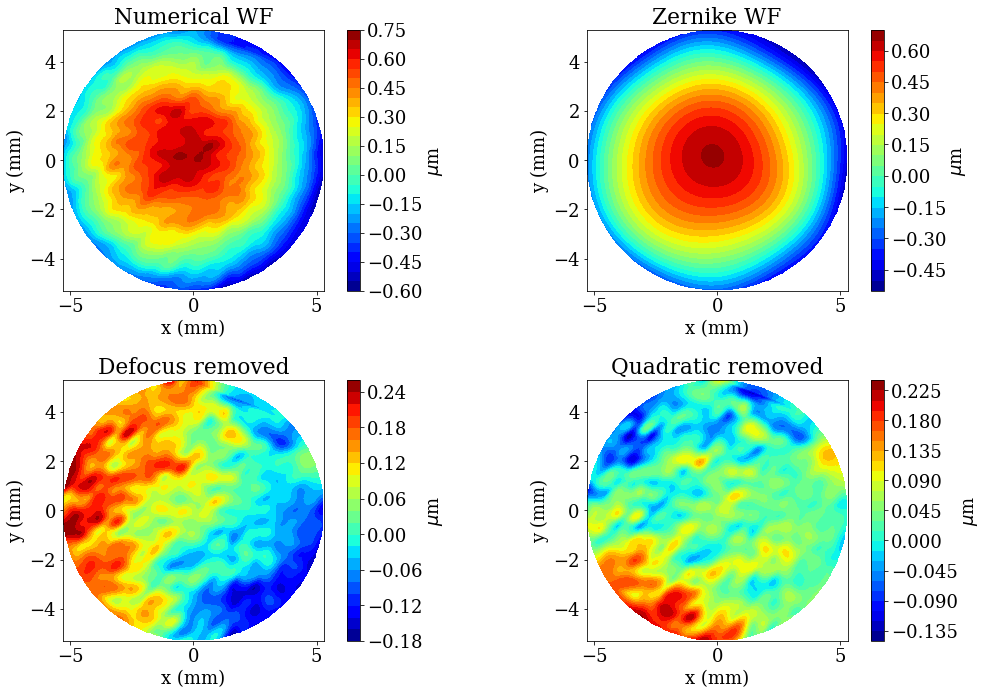

In [20]:
wfZ = HSM_Zernike.construct_wf(R,PHI, bcoeff)
wfZ_noS = HSM_Zernike.construct_wf(R,PHI, bcoeff_noS)
wfZ[X**2+Y**2>1]=np.nan
wfZ -= np.nan_to_num(wfZ).max()
wfZ = np.abs(wfZ) 
wfZ -= np.nan_to_num(wfZ).mean()
wfZ_noS[X**2+Y**2>1]=np.nan
wfZ_noS -= np.nan_to_num(wfZ_noS).max()
wfZ_noS = np.abs(wfZ_noS)
wfZ_noS -= np.nan_to_num(wfZ_noS).mean()

fig, axs = plt.subplots(2,2,figsize=(15,10))
pl1=axs[0,1].contourf(1e3*Rmax*ratio*X,1e3*Rmax*ratio*Y, 1e6*wfZ,25, cmap='jet')
cb1=plt.colorbar(pl1,ax=axs[0,1])
pl2=axs[1,0].contourf(1e3*Rmax*ratio*X,1e3*Rmax*ratio*Y, 1e6*wfn_noS,25, cmap='jet')
cb2=plt.colorbar(pl2,ax=axs[1,0])
pl3 = axs[0,0].contourf(1e3*Rmax*ratio*X,1e3*Rmax*ratio*Y, 1e6*wfn,25, cmap='jet')
cb3=plt.colorbar(pl3,ax=axs[0,0])
pl4 = axs[1,1].contourf(1e3*Rmax*ratio*X,1e3*Rmax*ratio*Y, 1e6*wfn_noquad,25, cmap='jet')
cb4=plt.colorbar(pl4,ax=axs[1,1])
cb1.set_label(r'$\mu$m')
cb2.set_label(r'$\mu$m')
cb3.set_label(r'$\mu$m')
cb4.set_label(r'$\mu$m')

axs[0,0].set_aspect('equal')
axs[0,0].set_xlabel('x (mm)')
axs[0,1].set_ylabel('y (mm)')
axs[0,0].set_ylabel('y (mm)')
axs[1,0].set_ylabel('y (mm)')
axs[1,0].set_xlabel('x (mm)')
axs[0,1].set_aspect('equal')
axs[0,1].set_xlabel('x (mm)')
axs[0,1].set_ylabel('y (mm)')
axs[1,0].set_aspect('equal')
axs[1,1].set_aspect('equal')
axs[1,1].set_xlabel('x (mm)')
axs[1,1].set_ylabel('y (mm)')
axs[0,0].set_title('Numerical WF')
axs[0,1].set_title('Zernike WF')
axs[1,0].set_title('Defocus removed')
axs[1,1].set_title('Quadratic removed')
plt.tight_layout()
plt.savefig('WF_150Vu_0.pdf')

In [21]:
from pykat import BeamParam
from pykat.optics.gaussian_beams import HG_mode
from pykat.optics.knm import riemann_HG_knm, makeCouplingMatrix, plot_knm_matrix
from pykat.optics.maps import curvedmap
from collections import defaultdict

In [22]:
# Since astigmatism is low, we compute higher order mode scattering only:
px = gspacing
N = np.shape(wfn_noS)[0]
x = np.arange(-N/2, N/2)*px
def gauss_amp(A, wx, wy, Rcx, Rcy, dx,dy):
    qx = BeamParam(rc=Rcx, w=wx)
    qy = BeamParam(rc=Rcy, w=wy)
    hg = HG_mode(qx, qy)
    #E  = A*rebin(hg.Unm(x-dx*px,x-dy*px), (512,512))
    E  = A*hg.Unm(x-dx*px,x-dy*px)
    return E
lambd = 1064e-9
k = 2*np.pi/lambd
w = 1e-3*np.arange(0.1,2,0.1)
HOMS = []
for iw in w:
    E0 = gauss_amp(1,iw,iw, 1e99, 1e99, 0, 0)
    E0[X**2+Y**2>1]=np.nan
    Erefl = np.nan_to_num(E0)*np.exp(1j*k*np.nan_to_num(wfn_noS))
    I0 = np.sum(np.nan_to_num(E0)*np.conjugate(Erefl)*px**2)
    I1 = np.sum(np.conjugate(np.nan_to_num(E0))*(Erefl)*px**2)
    I2 = np.sum(np.nan_to_num(E0)*np.conjugate(np.nan_to_num(E0))*px**2)
    HOMS.append((1-((I0*I1)/I2))*100 )# express in percentage


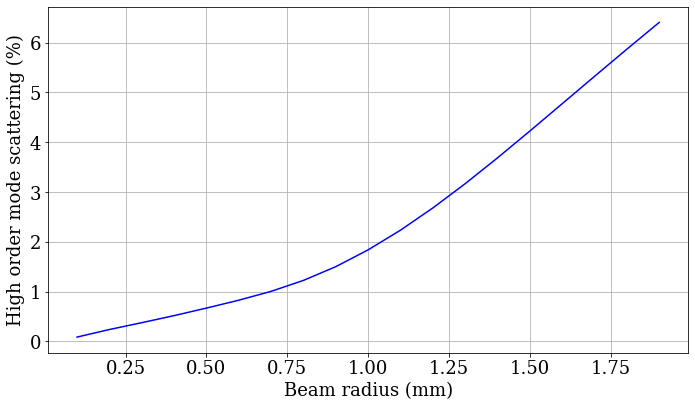

In [23]:
plt.figure(figsize=(10,6))
plt.plot(1e3*w,np.real(HOMS),'b')
plt.grid(which='both')
plt.xlabel('Beam radius (mm)')
plt.ylabel('High order mode scattering (%)')
plt.tight_layout()

In [91]:
qx = BeamParam(rc=1e99, w=iw)
qy = BeamParam(rc=1e99, w=iw)
C = makeCouplingMatrix(10)[0]
HGs = np.zeros( C.shape[0], dtype=complex)
for i,_ in enumerate(C):
    mode_in = _[:2]
    mode_out = _[2:]
    HGs[i]= riemann_HG_knm(x[::1], x[::1], mode_in, mode_out, qx, qx, qy, qy, Erefl)

## Using Zernike to quantify all defocus for all measuremnt:

In [97]:
iorder = 50
ratio = 1
Su_Z = [] 
Asu_Z = []
Sd_Z = [] 
Asd_Z = []
thetu_Z = []
thetd_Z = []
HOMS_u = []
HOMS_d = []
w = 1e-3*np.arange(0.1,2,0.1)

for iS in sets:
    # setting referenc
    if iS == 0:
        hsc_ref = hsc_ref0
    elif iS == 1:
        hsc_ref = hsc_ref1
    for iP in path:
        if iP == 'u':
            V_file=Vu_file
        else:
            V_file=Vd_file
        for ifile in range(0+iS,len(V_file),2):
            file = Image.open(ref_dir+V_file[ifile])
            live = np.array(file)[:,:,0]
            hsi_live = HS_Image()
            hsi_live.original_image = live
            hsi_live.background = 0
            hsi_live.process_image()
            hsc_live = HS_Centroids()
            hsc_live.hsimage = hsi_live
            hsc_live.radius = 10
            hsc_live.find_centroids_using_template(hsc_ref.centroids)
            hsg_raw = HS_Gradients(hsc_ref, hsc_live)
            hsg_raw.lever_arm = 4.1e-3
            hsg_raw.magnification = 1/0.71
            hsg_raw.pixel_size = 2*5.86e-6
            hsg_raw.construct_gradients()
            grad_notilt = hsg_raw.gradients[:,:2]-np.mean(hsg_raw.gradients[:,:2],axis=0)
            hsc_live1 = HS_Centroids()
            hsc_live1.centroids = hsc_ref.centroids + grad_notilt*(hsg_raw.lever_arm*hsg_raw.magnification/(hsg_raw.pixel_size))
            hsg = HS_Gradients(hsc_ref, hsc_live1)
            hsg.pixel_size = hsg_raw.pixel_size
            hsg.magnification = hsg_raw.magnification
            hsg.lever_arm = hsg_raw.lever_arm
            hsg.construct_gradients()
            mag=np.sqrt(np.sum(hsg.gradients[:,:2]**2,axis=1))
            hsg.origin = origin_new # Adjust the origin to put the deformation at the center
            hsg.construct_gradients()
            # Find  spherical power using fitting polynomial:
            hswfp = HS_WFP(hsg)
            bcoeff = HSM_Zernike.compute_Zernike_from_hsg(hsg,iorder,R0=ratio*Rmax)
            # Compute defocus  and astigmatism:
            W20 = 2*sqrt(3)*(bcoeff[3]) - 6*sqrt(5)*(bcoeff[11])-sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
            W22 = 2*sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
            #W40 = 6*sqrt(5)*(bcoeff[11]) 
            S = 2*W20/(ratio*Rmax)**2
            As =  W22/(ratio*Rmax)**2
            theta = np.rad2deg((np.arctan(bcoeff[4]/bcoeff[5])+np.pi)%(2*np.pi))
            # Compute  the residual wavefront with no S
            Rs = 2/S
            hsg_noS = HSM_Zernike.construct_residual_gradient(hsg, Rs)
            wfn_noS = HSM_WFN.calculate_wf(hsg_noS.gradients[:,2:],hsg_noS.gradients[:,:2],limits, gspacing)
            wfn_noS[X**2+Y**2>1]=np.nan
            wfn_noS -= np.min((np.nan_to_num(wfn_noS))[np.nonzero(np.nan_to_num(wfn_noS))])
            wfn_noS -= np.nan_to_num(wfn_noS).mean()
            
            # Compute higher order scattering
            HOMS = []
            for iw in w:
                E0 = gauss_amp(1,iw,iw, 1e99, 1e99, 0, 0)
                E0[X**2+Y**2>1]=np.nan
                Erefl = np.nan_to_num(E0)*np.exp(1j*k*np.nan_to_num(wfn_noS))
                I0 = np.sum(np.nan_to_num(E0)*np.conjugate(Erefl)*px**2)
                I1 = np.sum(np.conjugate(np.nan_to_num(E0))*(Erefl)*px**2)
                I2 = np.sum(np.nan_to_num(E0)*np.conjugate(np.nan_to_num(E0))*px**2)
                HOMS.append((1-((I0*I1)/I2))*100 )
            HOMS = np.transpose(HOMS)
            if iP == 'u':
                Su_Z.append(S)
                Asu_Z.append(As)
                thetu_Z.append(theta)
                HOMS_u.append(HOMS )
            else:
                Sd_Z.append(S)
                Asd_Z.append(As)
                thetd_Z.append(theta)
                HOMS_d.append(HOMS)
                
            print(V_file[ifile])

live_25u_0.bmp
live_50u_0.bmp
live_75u_0.bmp
live_100u_0.bmp
live_125u_0.bmp
live_150u_0.bmp
live_0d_0.bmp
live_25d_0.bmp
live_50d_0.bmp
live_75d_0.bmp
live_100d_0.bmp
live_125d_0.bmp
live_25u_1.bmp
live_50u_1.bmp
live_75u_1.bmp
live_100u_1.bmp
live_125u_1.bmp
live_150u_1.bmp
live_0d_1.bmp
live_25d_1.bmp
live_50d_1.bmp
live_75d_1.bmp
live_100d_1.bmp
live_125d_1.bmp


In [126]:
Sd_Z  = np.array(Sd_Z)
Sd_Z1 = Sd_Z.copy()
Sd_Z1[6:] -= Sd_Z1[6:].min()
Su_Z1 = np.array(Su_Z)
Su_Z1 = np.concatenate((Su_Z1,[Sd_Z1[0],Sd1[6]]))
zu = np.polyfit(np.concatenate((Vu_all,[0,0])), Su_Z1, 2)
pu= np.poly1d(zu)
V_fit = np.linspace(0,150,200)
Su_fit = pu(V_fit)

Sd_Z2 = np.concatenate((Sd_Z1,[Su_Z[5],Su_Z[11]]))
zd = np.polyfit(np.concatenate((Vd_all,[150,150])), Sd_Z2, 2)
pd= np.poly1d(zd)
Sd_fit = pd(V_fit)

Sall = np.concatenate((np.array(Su_Z),np.array(Sd_Z1)))
Pall = np.concatenate((np.array(Pu),np.array(Pd)))
zP = np.polyfit(Pall, Sall, 1)
pP= np.poly1d(zP)
VP_fit = np.linspace(Pall.min(), Pall.max(),100)
SP_fit = pP(VP_fit)

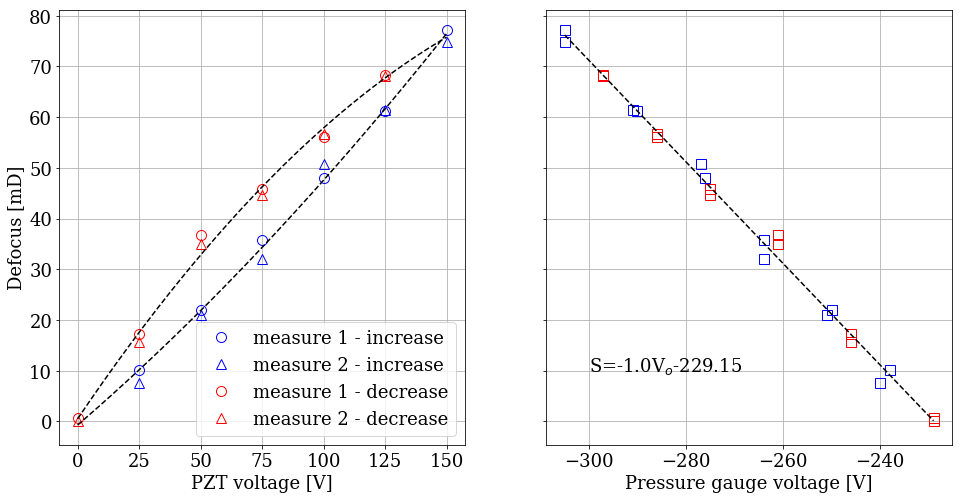

In [132]:
fig, axs = plt.subplots(1,2,figsize=(16,8),sharey=True)


axs[0].plot(Vu_all[:6],1e3*np.array(Su_Z)[:6],'ob',ms=10,mfc='none',label='measure 1 - increase')
axs[0].plot(Vu_all[6:],1e3*np.array(Su_Z)[6:],'^b',ms=10,mfc='none',label='measure 2 - increase')
axs[0].plot(Vd_all[:6],1e3*np.array(Sd_Z)[:6],'or',ms=10,mfc='none',label='measure 1 - decrease')
axs[0].plot(Vd_all[6:],1e3*np.array(Sd_Z1)[6:],'^r',ms=10,mfc='none',label='measure 2 - decrease')
axs[1].plot(Pu,1e3*np.array(Su_Z),'sb',ms=10,mfc='none')
axs[1].plot(Pd,1e3*np.array(Sd_Z1),'sr',ms=10,mfc='none')
axs[0].plot(V_fit,1e3*Su_fit,'--k',ms=10,mfc='none')
axs[0].plot(V_fit,1e3*Sd_fit,'--k',ms=10,mfc='none')
axs[1].plot(VP_fit,1e3*SP_fit,'--k',ms=10,mfc='none')

axs[1].text(-300,10,r'S={p0}V$_o${p1}'.format(p0=np.around(1e3*zP[0],2),p1=np.around(1e3*zP[1],2) ))

axs[0].legend()
axs[0].grid(which='both')
axs[1].grid(which='both')
axs[0].set_xlabel('PZT voltage [V]')
axs[1].set_xlabel('Pressure gauge voltage [V]')
axs[0].set_ylabel('Defocus [mD]')
plt.savefig('PZT_Actuation_range.pdf')

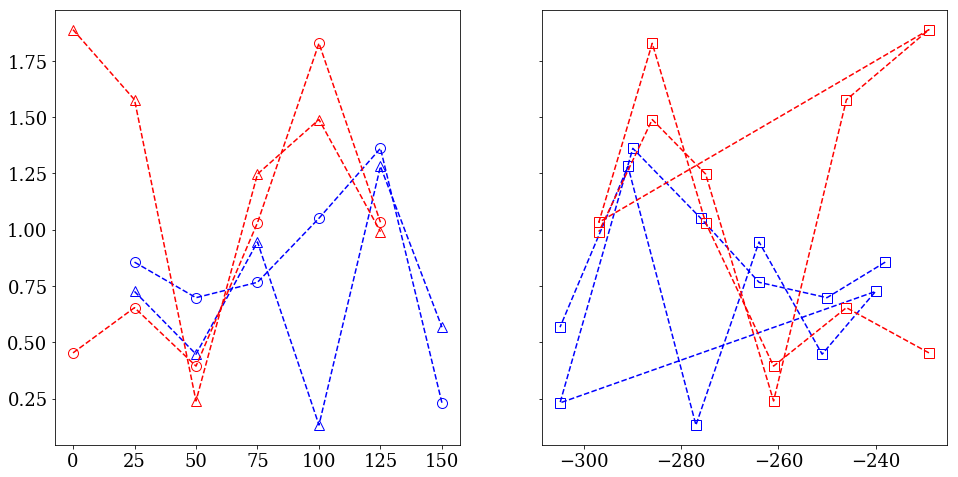

In [115]:
fig, axs = plt.subplots(1,2,figsize=(16,8),sharey=True)
axs[0].plot(Vu_all[:6],1e3*np.array(Asu_Z)[:6],'o--b',ms=10,mfc='none',label='measure 1 - increase')
axs[0].plot(Vu_all[6:],1e3*np.array(Asu_Z)[6:],'^--b',ms=10,mfc='none',label='measure 2 - increase')
axs[0].plot(Vd_all[:6],1e3*np.array(Asd_Z)[:6],'o--r',ms=10,mfc='none',label='measure 1 - decrease')
axs[0].plot(Vd_all[6:],1e3*np.array(Asd_Z)[6:],'^--r',ms=10,mfc='none',label='measure 2 - decrease')
axs[1].plot(Pu,1e3*np.array(Asu_Z),'sb--',ms=10,mfc='none')
axs[1].plot(Pd,1e3*np.array(Asd_Z),'sr--',ms=10,mfc='none')

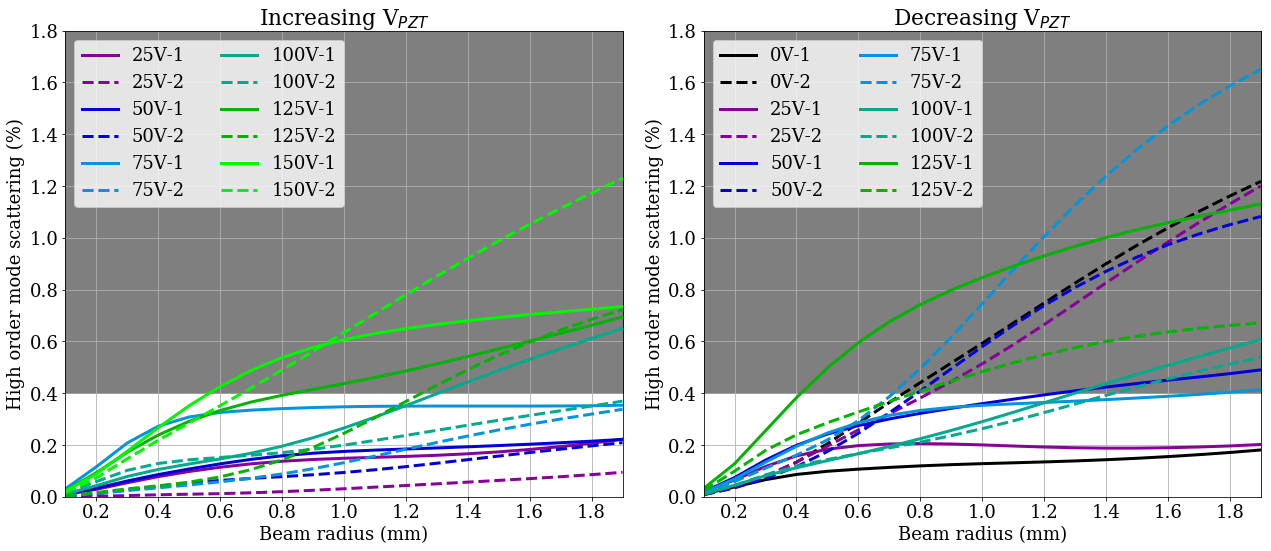

In [156]:
# Plotting highe order mode scattering:
x = np.linspace(np.min(1e3*w),np.max(1e3*w),10)
y = 0.4*np.ones(len(x))
fig, axs = plt.subplots(1,2, figsize =(18,8))
nlines = np.shape(Vu_all[:6])[0]
color_idx = np.linspace(0.2, 1, nlines)
for i,_ in enumerate(Vu_all[:6]):
    axs[0].plot(1e3*w,np.real(HOMS_u[i]),linewidth=3, color=plt.cm.nipy_spectral(_),label='{iV}V-1'.format(iV=_))
    axs[0].plot(1e3*w,np.real(HOMS_u[6+i]),'--',linewidth=3, color=plt.cm.nipy_spectral(_),label='{iV}V-2'.format(iV=_))
axs[0].legend(ncol=2)
axs[0].grid(which='both')
for i,_ in enumerate(Vd_all[:6]):
    axs[1].plot(1e3*w,np.real(HOMS_d[i]),linewidth=3, color=plt.cm.nipy_spectral(_),label='{iV}V-1'.format(iV=_))
    axs[1].plot(1e3*w,np.real(HOMS_d[6+i]),'--',linewidth=3, color=plt.cm.nipy_spectral(_),label='{iV}V-2'.format(iV=_))
axs[1].fill_between(x, y, y2=1.8,color='k',alpha=0.5)
axs[0].fill_between(x, y, y2=1.8,color='k',alpha=0.5)

axs[1].legend(ncol=2)
axs[1].grid(which='both')
axs[1].set_xlabel('Beam radius (mm)')
axs[0].set_xlabel('Beam radius (mm)')
axs[1].set_title(r'Decreasing V$_{PZT}$')
axs[0].set_title(r'Increasing V$_{PZT}$')
axs[0].set_ylabel('High order mode scattering (%)')
axs[1].set_ylabel('High order mode scattering (%)')
axs[0].set_xlim([np.min(1e3*w),np.max(1e3*w)])
axs[1].set_xlim([np.min(1e3*w),np.max(1e3*w)])
axs[0].set_ylim([0,1.8])
axs[1].set_ylim([0,1.8])
plt.tight_layout()
plt.savefig('Higher_order_mode_scattering.pdf')

In [103]:
shape(HOMS_u)[1]

19